# Generative models

Grzegorz Statkiewicz, Mateusz Matukiewicz

## Setup

In [1]:
!nvidia-smi

Mon May 12 21:18:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti     On  |   00000000:1C:00.0  On |                  N/A |
|  0%   48C    P8             19W /  130W |     753MiB /   6144MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch

Select the device to use

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


## Prepare the dataset and dataloaders

In [8]:
from torchvision import transforms

# train_mean = [0.3186241388320923, 0.2931755483150482, 0.3017965853214264]
# train_std = [0.2762017846107483, 0.2654302418231964, 0.2686000168323517]

train_mean = [0.5, 0.5, 0.5]
train_std = [0.5, 0.5, 0.5]


class ContrastStretch(object):
    def __call__(self, img):
        # img: Tensor [C,H,W] in [0,1]
        lo, hi = img.min(), img.max()
        return (img - lo) / (hi - lo + 1e-5)

transform = transforms.Compose([
    transforms.ToTensor(),
    ContrastStretch(),
    transforms.Normalize(mean=train_mean, std=train_std),
])

In [9]:
from torchvision.datasets import ImageFolder

train_dir = "./data/train"
train_ds = ImageFolder(train_dir, transform=transform)

num_classes = len(train_ds.classes)

print(f"Number of train images: {len(train_ds)}")
print(f"Number of train classes: {num_classes}")

Number of train images: 31367
Number of train classes: 43


In [10]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# VAE

## Create model

In [11]:
from gnn import VariationalAutoencoder as VAE
from gnn import VAETrainer
import torch.optim as optim
import torch.nn as nn


IMG_CHANNELS = 3
latent_dim = 2

# model
vae_model = VAE(IMG_CHANNELS, latent_dim=latent_dim).to(device)

# optimizers
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.0001)
vae_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=vae_optimizer, gamma=0.99)

# trainer
vae_trainer = VAETrainer(
    vae_model=vae_model,
    optimizer=vae_optimizer,
    scheduler=vae_scheduler,
    latent_dim=latent_dim,
    device=device
)

## Training

Epoch 1/1: Total Loss: 727.2085, Recon Loss: 718.0390, KLD Loss: 9.1695


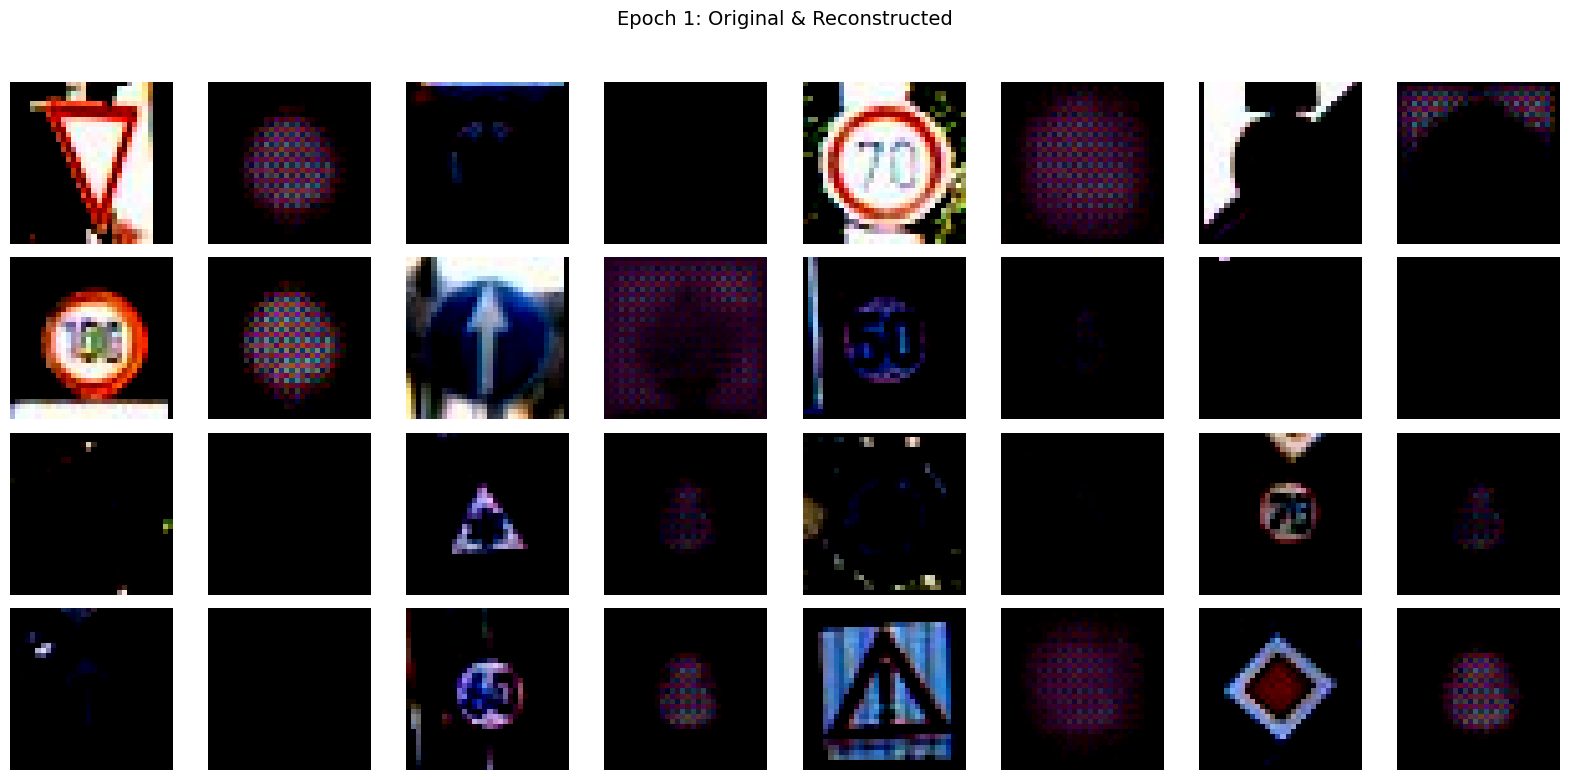

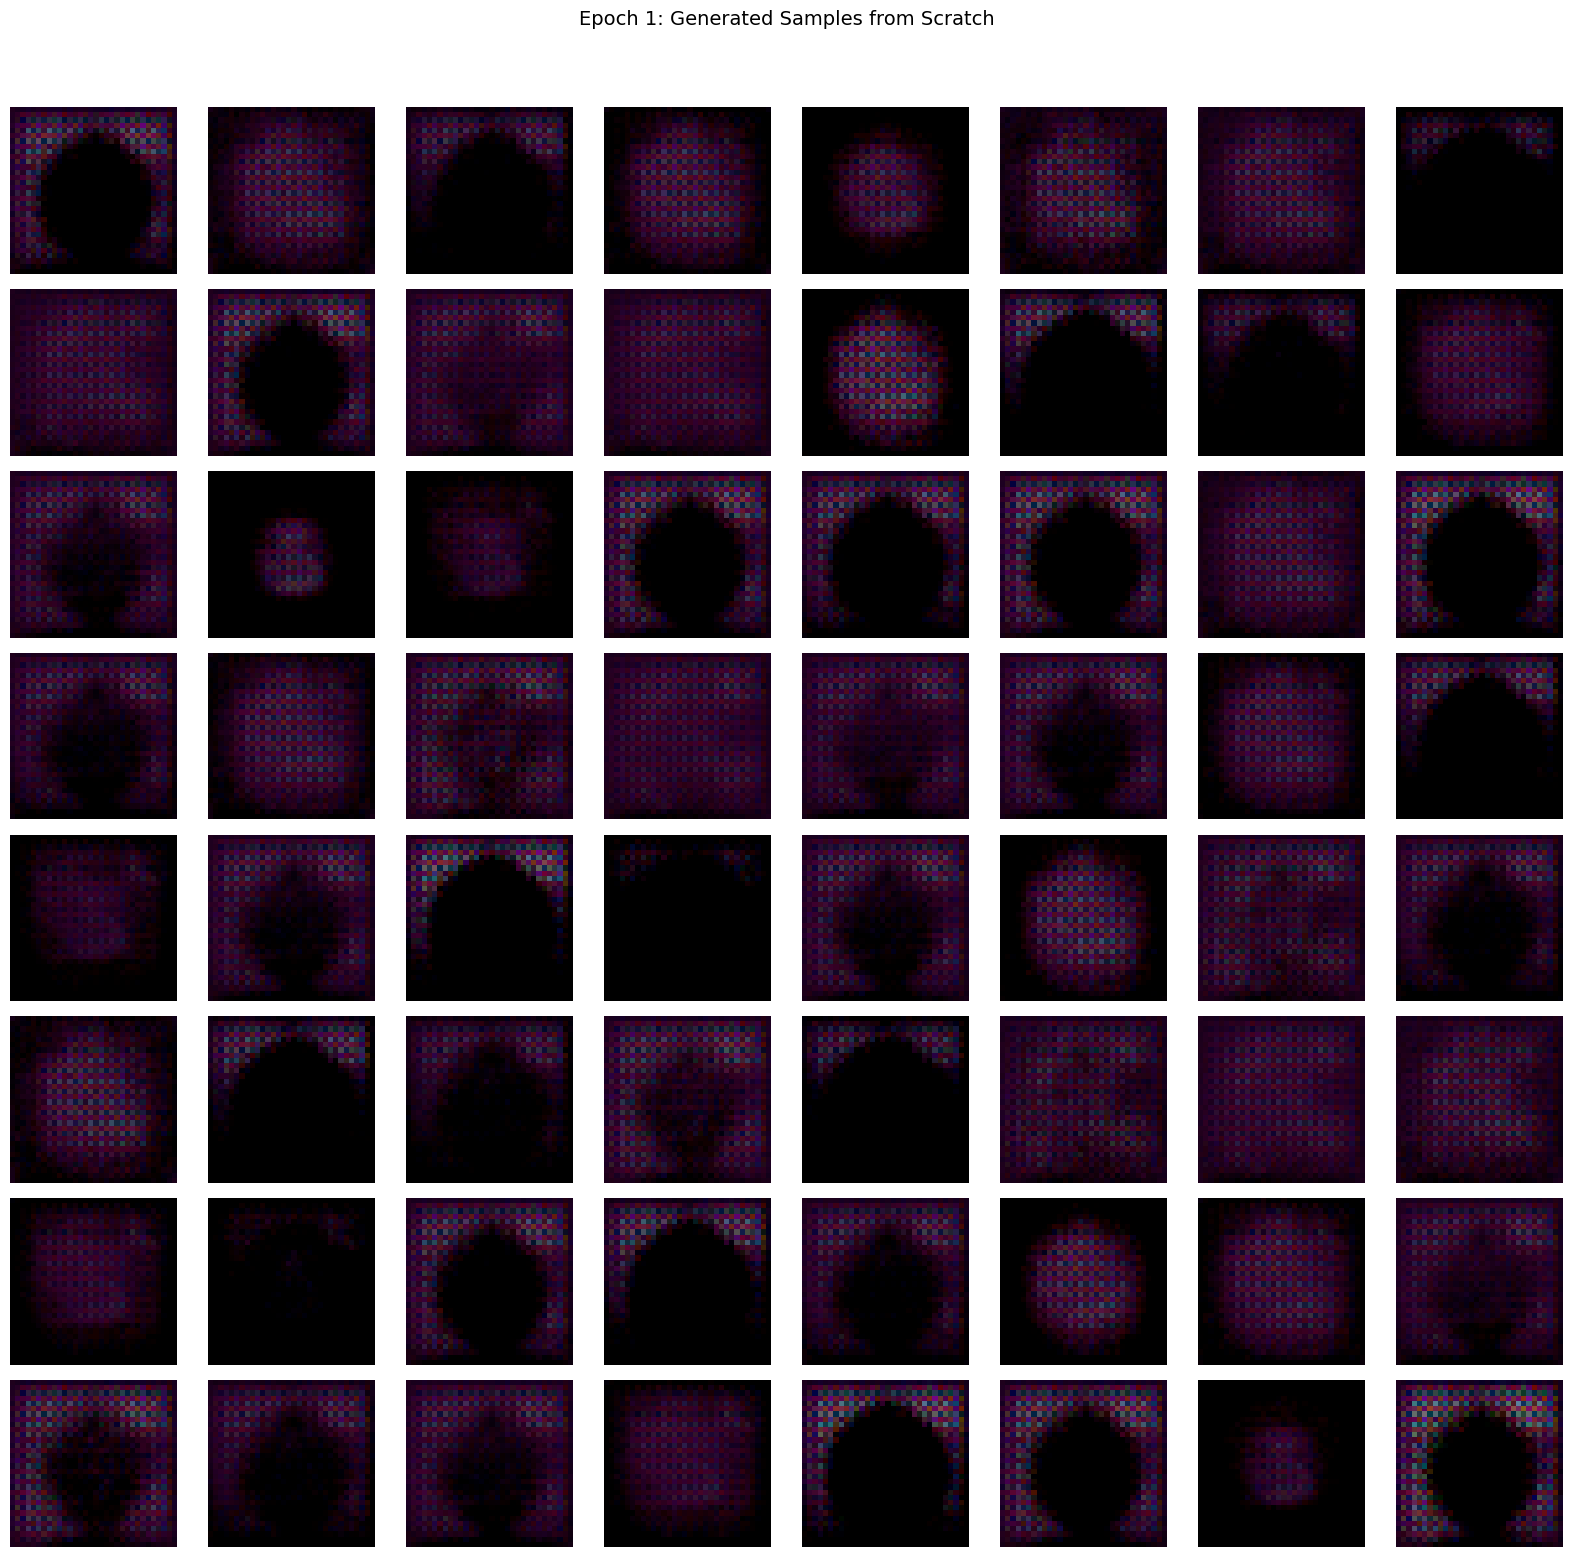

{'total_losses': [727.2084962178052],
 'reconstruction_losses': [718.0389765297494],
 'kld_losses': [9.169521249532586]}

In [ ]:
vae_trainer.fit(train_dl, num_epochs=1)

In [51]:
len(test_ds)
x,y = test_ds[7081]
print(x)
print(y)

<PIL.Image.Image image mode=RGB size=32x32 at 0x7FBC0EBF7C10>
36


In [52]:
import os
import time
from torchvision.utils import save_image

results_id = time.time()
results_dir = f"./vae_results/{results_id}"
os.makedirs(results_dir, exist_ok=True)

mean_t = torch.tensor(train_mean).view(1, 3, 1, 1).to(device)
std_t = torch.tensor(train_std).view(1, 3, 1, 1).to(device)

vae_model.eval()

num_samples = len(test_ds)

with torch.no_grad():
    for i in range(num_samples):
        sample, label = test_ds[i]


        z = torch.randn(1, latent_dim, device=device)
        img = vae_model.decode(z)

        img = img * std_t + mean_t

        fname = os.path.join(results_dir, f"class_{label}_sample_{i}.jpg")
        save_image(img.clamp(0, 1), fname)


Calculate the FID between test set and generated images

In [53]:
from pytorch_fid.fid_score import calculate_fid_given_paths

test_flat_dir = "./data/test_flat"
generated_dir = results_dir

fid = calculate_fid_given_paths([test_flat_dir, generated_dir], batch_size, device, dims=2048, num_workers=1)

print(f"FID: {fid}")

100%|██████████| 62/62 [00:24<00:00,  2.52it/s]


FID: 294.75305200959156
